# Import Libraries

In [1]:
# Data acquisition, aggregation, and visualization
from raw_data import download_data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ML and Tuning
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, selu, tanh, linear
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
import keras_tuner as kt

# Data Prep

### Prep Retrieve data from Kaggle

In [2]:
# Get csv data from kaggle
dataPath = download_data()
df = pd.read_csv(dataPath)

C:\Users\ihodgki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Validate Date Field and Extract Components

In [3]:
# Ensure Date field is being read as datetime. Break into Year, Month, and WeekOfYear
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["WeekOfYear"] = df["Date"].dt.isocalendar().week

# EDA

### Summarize Dataset

In [4]:
# Descriptive Statistics
styled_describe = df.describe().style.format(precision=2).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center'), ('font-weight', 'bold')],
}])
print("Descriptive Statistics:")
display(styled_describe)

Descriptive Statistics:


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear
count,6435.00,6435,6435.00,6435.00,6435.00,6435.00,6435.00,6435.00,6435.00,6435.00,6435.00
mean,23.00,2011-06-17 00:00:00,1046964.88,0.07,60.66,3.36,171.58,8.00,2010.97,6.45,25.82
min,1.00,2010-02-05 00:00:00,209986.25,0.00,-2.06,2.47,126.06,3.88,2010.00,1.00,1.00
25%,12.00,2010-10-08 00:00:00,553350.10,0.00,47.46,2.93,131.74,6.89,2010.00,4.00,14.00
50%,23.00,2011-06-17 00:00:00,960746.04,0.00,62.67,3.44,182.62,7.87,2011.00,6.00,26.00
75%,34.00,2012-02-24 00:00:00,1420158.66,0.00,74.94,3.73,212.74,8.62,2012.00,9.00,38.00
max,45.00,2012-10-26 00:00:00,3818686.45,1.00,100.14,4.47,227.23,14.31,2012.00,12.00,52.00
std,12.99,nan,564366.62,0.26,18.44,0.46,39.36,1.88,0.80,3.24,14.13


### Check for Null Values

In [5]:
# Display Null Values
null_counts = df.isnull().sum().reset_index()
null_counts.columns = ['Column', 'Null Count']
styled_nulls = null_counts.style.set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center'), ('font-weight', 'bold')],
}])

print("\nNull Value Counts:")
display(styled_nulls)


Null Value Counts:


,Column,Null Count
0,Store,0
1,Date,0
2,Weekly_Sales,0
3,Holiday_Flag,0
4,Temperature,0
5,Fuel_Price,0
6,CPI,0
7,Unemployment,0
8,Year,0
9,Month,0


### Visuals

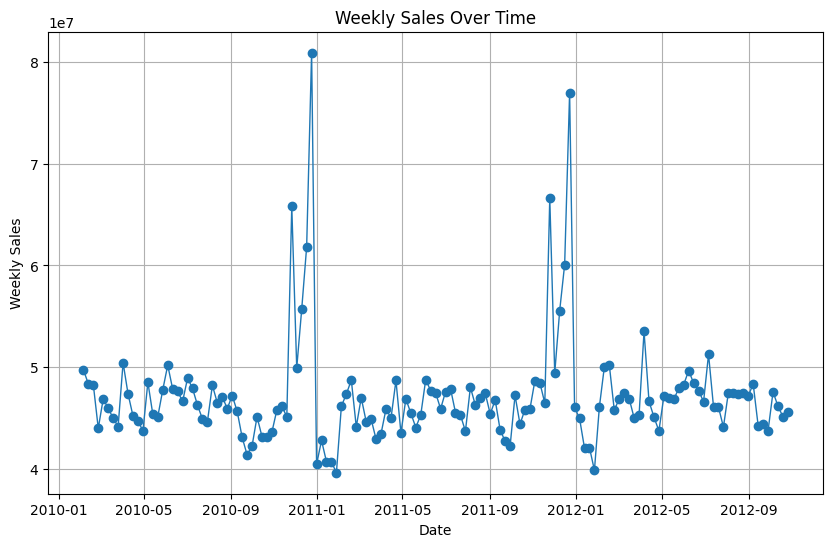

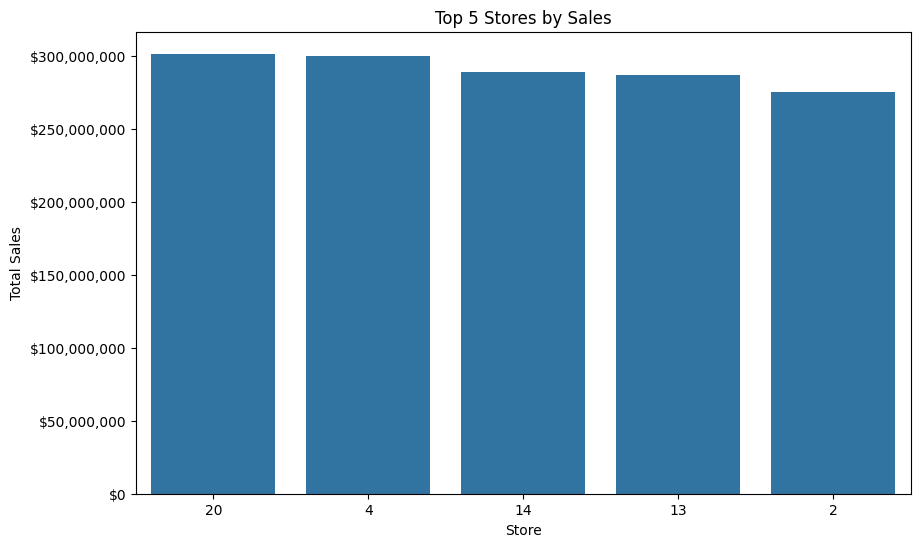

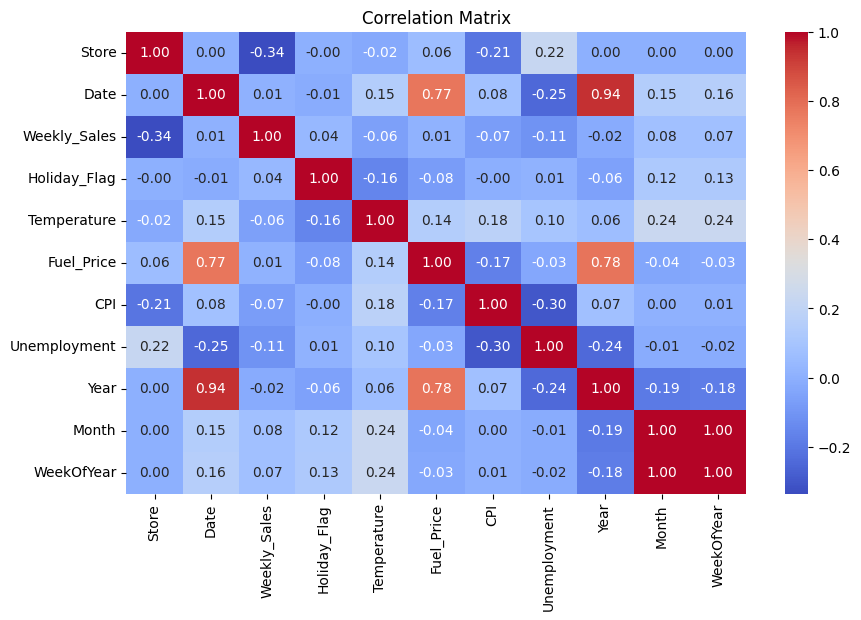

In [6]:
# Line graph: Sales by Date
sales_by_date = df.groupby("Date")["Weekly_Sales"].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(sales_by_date["Date"], sales_by_date["Weekly_Sales"], marker='o', linestyle='-', linewidth=1)
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.grid()
plt.show()


# Bar graph: Top 5 Stores by Sales
top_5_stores = df.groupby("Store")["Weekly_Sales"].sum().nlargest(5).reset_index()
top_5_stores = top_5_stores.sort_values(by="Weekly_Sales", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Store", 
    y="Weekly_Sales", 
    data=top_5_stores, 
    order=top_5_stores["Store"],
)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.title("Top 5 Stores by Sales")
plt.xlabel("Store")
plt.ylabel("Total Sales")
plt.show()


# Plot correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Deep Learning

### Train Test Split

In [7]:
# Split the dataset into training and testing sets
x = df.drop(columns=["Weekly_Sales", "Date"])
y = df["Weekly_Sales"]

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### FNN Neural Network Hyperband Tuning

In [8]:
# Optimize nodes, learning rate, dropout rate, and activation functions
from tensorflow.keras import Input

def model_builder(hp):
    model = Sequential()
    
    # Add the Input layer
    model.add(Input(shape=(X_train.shape[1],)))
    
    # Tune the number of units in the first Dense layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=96, step=32)
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'selu', 'tanh', 'linear'])
    model.add(Dense(units=hp_units_1, activation=hp_activation_1))
    
    # Add Dropout layer after the first Dense layer
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.2, step=0.1)
    model.add(Dropout(rate=hp_dropout_rate))

    # Add additional dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=2, step=1)
    for i in range(num_dense_layers - 1):
        units_name = f'units_{i + 2}'
        hp_units = hp.Int(units_name, min_value=32, max_value=96, step=32)
        hp_activation = hp.Choice(f'activation_{i + 2}', values=['relu', 'linear'])
        model.add(Dense(units=hp_units, activation=hp_activation))

    model.add(Dense(1, activation='linear'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=MeanSquaredError(),
                  metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model



# Set Tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparameter_tuning_logs',
                     project_name='model1')


# Create Callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


# Run Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of dense layers is {best_hps.get('num_dense_layers')} 
with the following configurations:
""")
for i in range(1, best_hps.get('num_dense_layers') + 1):
    units = best_hps.get(f'units_{i}')
    activation = best_hps.get(f'activation_{i}')
    print(f"  - Dense Layer {i}: Units = {units}, Activation = {activation}")
print(f"The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")
print(f"The optimal dropout rate is {best_hps.get('dropout_rate')}.")

Trial 30 Complete [00h 00m 05s]
val_loss: 287161614336.0

Best val_loss So Far: 241326997504.0
Total elapsed time: 00h 01m 41s

The hyperparameter search is complete. The optimal number of dense layers is 2 
with the following configurations:

  - Dense Layer 1: Units = 96, Activation = selu
  - Dense Layer 2: Units = 96, Activation = linear
The optimal learning rate for the optimizer is 0.01.
The optimal dropout rate is 0.1.


### Tune for Epoch

In [9]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1392054894592.0000 - mean_absolute_error: 1039911.0000 - root_mean_squared_error: 1179821.1250 - val_loss: 1307198226432.0000 - val_mean_absolute_error: 991316.3750 - val_root_mean_squared_error: 1143327.7500
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1203550420992.0000 - mean_absolute_error: 943657.3125 - root_mean_squared_error: 1095482.0000 - val_loss: 729303678976.0000 - val_mean_absolute_error: 688126.3125 - val_root_mean_squared_error: 853992.8125
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 551766917120.0000 - mean_absolute_error: 589284.5000 - root_mean_squared_error: 741711.2500 - val_loss: 334583332864.0000 - val_mean_absolute_error: 456984.9062 - val_root_mean_squared_error: 578431.8125
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 303545712640.0000 - mean_absolute_error: 442857.5000 - root_mean_squared_error: 550849.7500 - val_loss: 282485129216.0000 - val_mean_absolute

### Finalize Model

In [10]:
# Retrain the model with best epoch
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

# Evaluate Final Model
eval_result = hypermodel.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
print("[test loss, root mean squared error, mean absolute error]:", eval_result)

Epoch 1/49
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1402686930944.0000 - mean_absolute_error: 1041012.9375 - root_mean_squared_error: 1184202.3750 - val_loss: 1299028115456.0000 - val_mean_absolute_error: 988267.0625 - val_root_mean_squared_error: 1139749.1250
Epoch 2/49
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1152864747520.0000 - mean_absolute_error: 916648.2500 - root_mean_squared_error: 1072835.6250 - val_loss: 685973766144.0000 - val_mean_absolute_error: 670053.3125 - val_root_mean_squared_error: 828235.3125
Epoch 3/49
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 542891835392.0000 - mean_absolute_error: 591553.8750 - root_mean_squared_error: 734743.3125 - val_loss: 324586930176.0000 - val_mean_absolute_error: 447940.3438 - val_root_mean_squared_error: 569725.3125
Epoch 4/49
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 307296927744.0000 - mean_absolute_error: 450756.4375 - root_mean_squared_error: 554122.8750 - val_loss: 278867509248.0000 - val_mean_absolute

### Plot Results

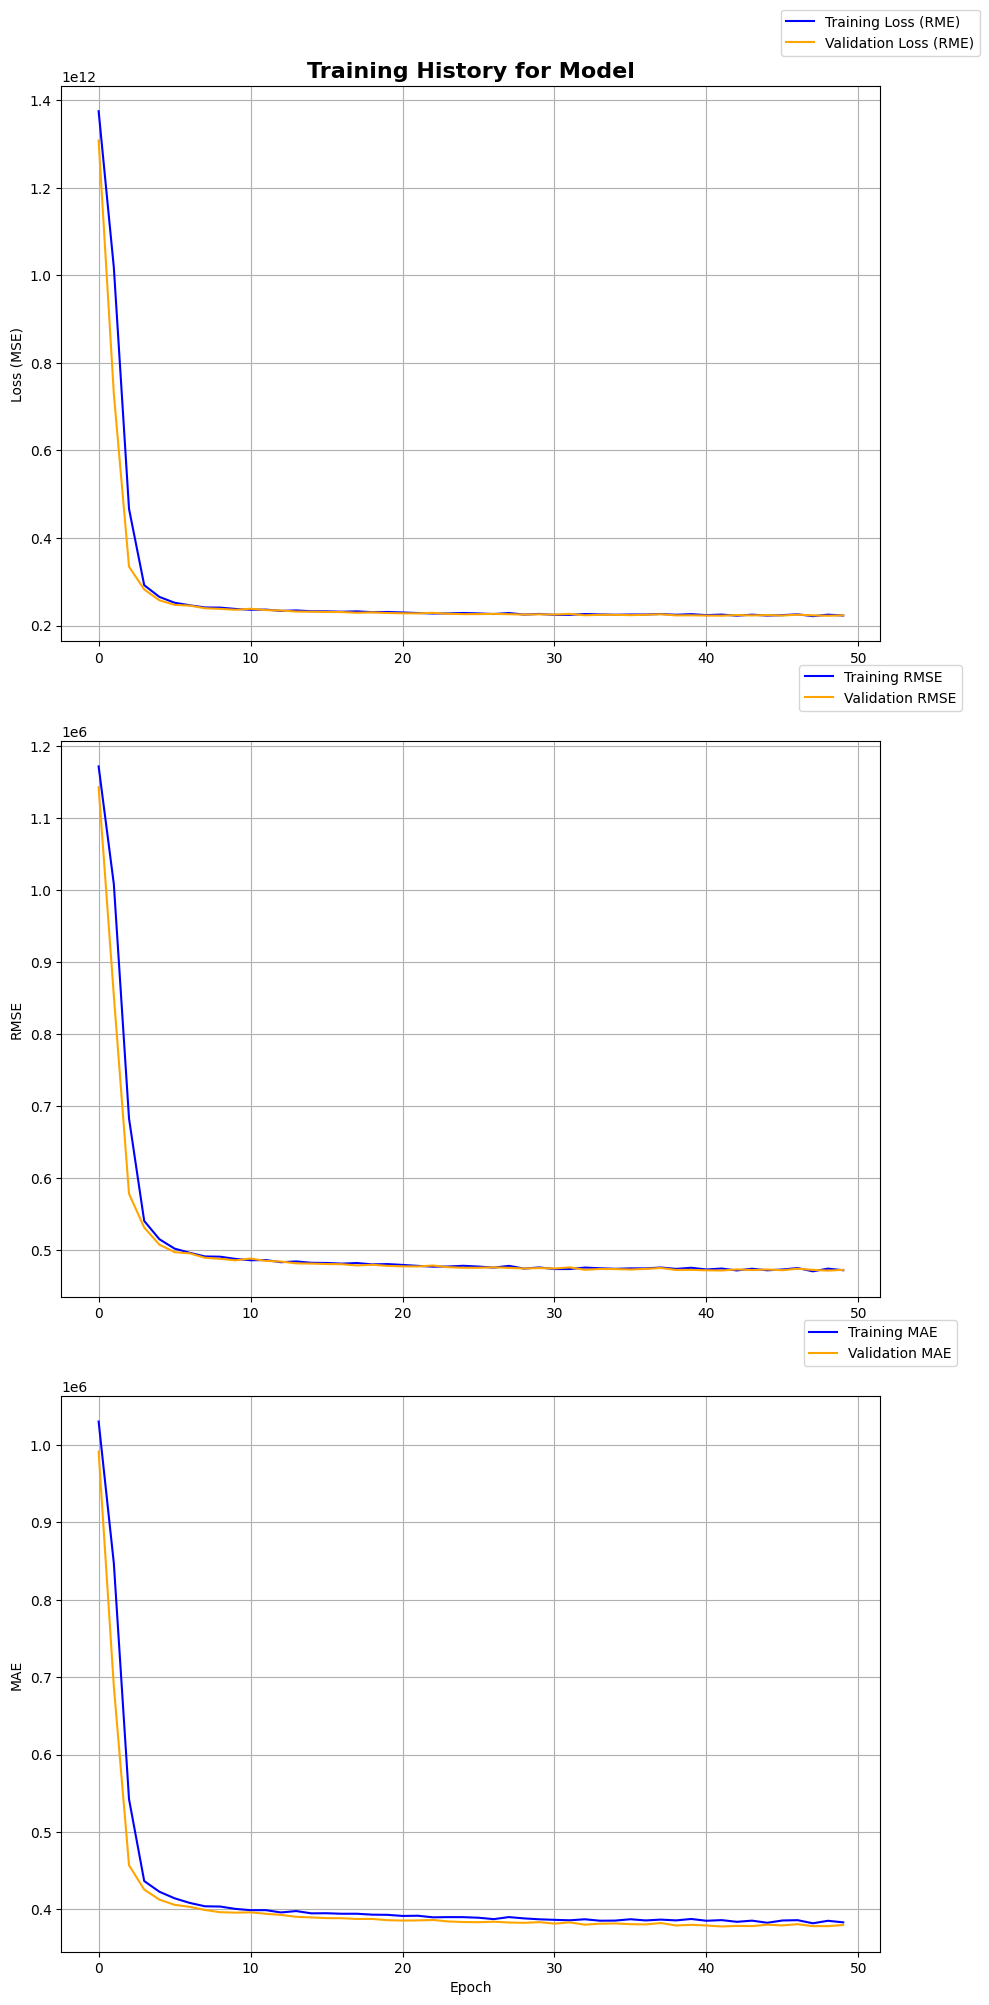

In [11]:
# Create plots for model training history
plt.figure(figsize=(10, 20))

# Loss plot
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], label='Training Loss (RME)', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss (RME)', color='orange')
plt.title('Training History for Model', fontsize=16, fontweight='bold')
plt.ylabel('Loss (MSE)')
plt.legend(loc='upper center', bbox_to_anchor=(1, 1.15))
plt.grid(True)

# RMSE plot
plt.subplot(3, 1, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE', color='blue')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE', color='orange')
plt.ylabel('RMSE')
plt.legend(loc='upper center', bbox_to_anchor=(1, 1.15))
plt.grid(True)

# MAE plot
plt.subplot(3, 1, 3)
plt.plot(history.history['mean_absolute_error'], label='Training MAE', color='blue')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper center', bbox_to_anchor=(1, 1.15))
plt.grid(True)

plt.tight_layout()
plt.show()